# Homework 6 - Dimension Reduction

In this homework, we will work on some problems involving fitting and dimension reduction. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

## Preamble

The following method will be used in the next problem. It generates noisy samples from a sphere.

In [2]:
def sample_noisy_sphere(n, **kw):
    """
    Sample n points uniformly at random from the l-sphere
    embedded in d dimensions.
    
    Add normal nosie with variance sigma
    
    Arguments:
        n - number of samples
    
    Optional arguments:
        r - radius of circle (default 1.0)
        l - dimension of sphere (default l = 1 == circle)
        sigma - noise variance (default 0.1)
        d - dimension of embedded space (default l+1)
    """
    r = kw.get('r', 1.0)
    l = kw.get('l', 1)
    sigma = kw.get('sigma', 0.1)
    d = kw.get('d', k+1)

    X = np.random.randn(n,l+1)
    X = r * X / np.linalg.norm(X, axis=1).reshape(n, -1) # project onto sphere
    
    Q, R = np.linalg.qr(np.random.randn(d, k+1))
    X = X @ Q.T # apply random rotation

    return X + sigma*np.random.randn(n, d)

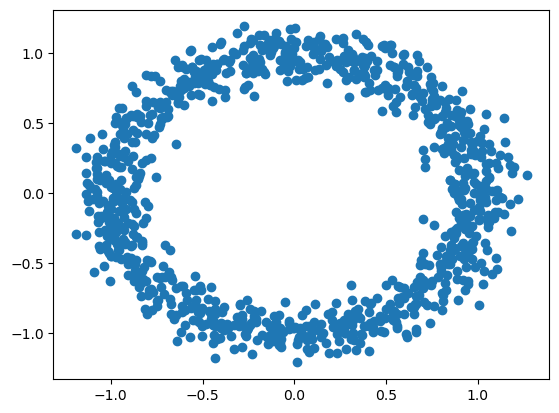

In [3]:
X = sample_noisy_sphere(1000, d=2)
plt.scatter(X[:,0], X[:,1])
plt.show()

## Problem 0 - Multidimensional Scaling (20 points)

[Mulitdimensional scaling (MDS)](https://en.wikipedia.org/wiki/Multidimensional_scaling) is a method which looks for an embedding of $n$ data points into a (lower-dimensional) Euclidean space that preserves pairwise distances as much as possible. In other words, given a set of data points $z_0,\dots,z_{n-1}$ and a distance function $d$ measuring the distance between them, then we want to find $x_0,\dots,x_{n-1} \in \mathbb{R}^k$ such that
$$\|x_i - x_j \| \approx d(z_i,z_j), \quad 0 \le i,j \le n-1.$$

First off, we note that if $N>k,$ generally it will not be possible to get equality (think about $(1,0,0,0,\dots),(0,1,0,0\dots),\cdots,$ but we want to get as close as possible.

---

Let's first start with the simple case where $d$ is the standard Euclidean distance and get some intuition. We can construct the matrix of pairwise distances, $D,$ by setting $D_{i,j} = d(z_i,z_j,)^2.$ Now, let's assume that there was an exact solution. So, there exist $x_1,\dots,x_{n-1} \in \mathbb{R}^k$ such that 
$$D_{i,j} = \|x_i-x_j\|^2,\quad 0 \le i,j \le {n-1}.$$
Let's set $X$ to be the $n\times k$ matrix whose $i$th row is $x_i.$ Then, 
$$D = \vec{1} w^T +w \vec{1}^T -2 X X^T$$
where $w = (\|x_0\|,\|x_2\| ,\dots, \|x_{n-1}\|)^T$ and $\vec{1}$ is the vector of all ones with length $n.$

From this, it is easy to see that $D$ will not change if we shift all $x_i$'s by the same vector (shifting every data point preserves pairwise distances), or rotate them all using an orthogonal matrix $Q,$ since those transformations preserve pairwise distances. So, if we want to recover the $x_i$'s from $D$ we can only do it up to a global translation and rotation. 

Thus, without loss of generality, we can "center" the matrix $X$ so that columns sum to 0, setting $Y = (I - \frac{1}{n}\vec{1}\vec{1}^T) X$.  Let's call this projection matrix $J = (I - \frac{1}{n}\vec{1}\vec{1}^T)$ the "centering matrix". In particular, note that $J \vec{1} = (I - \frac{1}{n}\vec{1}\vec{1}^T )\vec{1} = \vec{1} - \vec{1} = \vec{0}$, so the nullspace of $J$ consists of constant vectors, as expected.

The problem now is, given $D,$ find $Y$ up to a global rotation. Looking at the formula for $D,$ if the first two terms were not there, the problem would be easy. we would want to find an $n\times k$ matrix $X$ such that $D = -2 X X^T.$ This is nothing but a rank $k$ approximation to $D,$ and can be found using the eigendecomposition!

Let's see how to do this. If we define
\begin{equation}
B = -\frac{1}{2}J D J^T
\end{equation}
then, looking at the definition of $D,$ we see that
$$B = J X X^T J^T = YY^T.$$ 
Thus we can recover $Y=JX$ (up to a global rotation - i.e. the same rotation is applied to every data point) using an eigenvalue decomposition. Specifically, if $B = V \Lambda V^T$ then one solution for $Y$ is given by $Y=  V_k\Lambda^{1/2},$ where $V_k$ spans the largest $k$-dimensional eigenspace and $\Lambda_k$ is the diagonal matrix with the associated eigenvalues.

More generally, if the problem is not exactly solvable, we could try to solve the optimization problem
\begin{equation}
\mathop{\textsf{minimize}}_{Z} \|B - ZZ^T\|_F
\end{equation}
Where $X$ is the embedding coordinates (an $n\times k$ matrix), and $\|\cdot \|_F$ is the Frobenius matrix norm $\|A\|_F = \sqrt{\sum_{i,j} A_{i,j}^2}$.
As before, since $B$ and $ZZ^T$ are symmetric, an optimal solution is given by the optimal rank-$k$ approximation to $B$, which can again be computed using an eigenvalue decomposition
\begin{equation}
B = V \Lambda V^T
\end{equation}
And setting $Z = V_k \Lambda^{1/2}_k.$

Putting it altogether, we see that we have an algorithm for recovering a Euclidean embedding from the matrix of pairwise distances.  Note that there is nothing stopping us from finding a Euclidean embedding when $D$ does not come from Euclidean distances, but from some other metric.  In this case, the recovered $Z$ will give coordinates which "optimally" respect the original metric, even when the original metric can't be embedded in Euclidean space.

We now have an algorithm for data visualization given pairwise distance information, the classical MDS algorithm:
1. Form the matrix $D$ so $D_{i,j} = d(x_i, x_j)^2$ (even when the distance $d$ isn't Euclidean).
See [here](https://caam37830.github.io/book/08_geometry/distances.html#pairwise-distances) for helpful routines and pointers to more information.
2. Form the matrix $B = -\frac{1}{2} J D J^T$
3. Compute the eigenvalue decomposition $B = V\Lambda V^T$
4. Return a $k$-dimensional embedding $Z
= V_k \Lambda_k^{1/2}$ (recall that for `eigh` $V_k$ is the last `k` columns of the eigenvector matrix)

Finally, note there are a variety of variations to MDS.  The one we're implementing is probably the simplest.

### Part A - Center a Matrix (5 points)

Write a function `center_matrix(D)` which given a matrix $D$ returns the matrix $-\frac{1}{2} J D J^T$. You should make this code faster than simply forming $J$ and multiplying.

In [4]:
## Your code here


### Part B - Implement the MDS algorithm (5 points)

Write a function `MDS(D, k=2)` computes $B=-\frac{1}{2} J D J^T$, computes its eignvalue decomposition and then returns the `k`-dimensional Euclidean embedding for a matrix of pairwise distances `D`.

In [5]:
## Your code here


### Part C - Use your implementation (10 points)

Use the noisy circle data in the preamble section for your input data `X` with $d=20$ and $l=2$.  Use your `MDS` function with $k=2$ to get coordinates for the data after computing pairwise distances with the following metrics.  Visualize each embedding using a scatter plot.

1. Euclidean Metric
2. $L^1$ metric (`cityblock` in scipy)
3. $L^\infty$ metric (`chebyshev` in scipy)
4. Cosine distance (`cosine` in scipy)

How does the embedding depend on the choice of metric?

In [6]:
## Your code here


### Part D (5 points)
In this problem we explore how the underlying dimension of the data affects the output of the MDS algorithm.

Make some visualizations for 1-, 2-, and 5-spheres in $d=20$ dimensions. Is the two dimensional embedding of the 5-sphere informative?